In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from dataset import DataSet
from eztao.carma import DRW_term, DHO_term
from eztao.ts import gpSimRand
import os
import utils
import sys
import model
import torch.optim as optim
import logging
from eztao.carma import DRW_term, DHO_term
from dataset import DataSet
from eztao.ts import gpSimRand, gpSimFull
import time 

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
     

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [203]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


validated 1 files out of 1 for band='g'
created union_tp attribute of length 435
dataset created w/ shape (11, 1, 435, 3)
train size: 8, valid size: 2, test size: 3


/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_55669/3101178381.py:27: RankWarning: Polyfit may be poorly conditioned
  lcs.prune_graham(plot=True, index=0)
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_55669/3101178381.py:27: RankWarning: Polyfit may be poorly conditioned
  lcs.prune_graham(plot=True, index=0)
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_55669/3101178381.py:27: RankWarning: Polyfit may be poorly conditioned
  lcs.prune_graham(plot=True, index=0)
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_55669/3101178381.py:27: RankWarning: Polyfit may be poorly conditioned
  lcs.prune_graham(plot=True, index=0)
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_55669/3101178381.py:27: RankWarning: Polyfit may be poorly conditioned
  lcs.prune_graham(plot=True, index=0)
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_55669/3101178381.py:27: RankWarning: Polyfit may be poorly conditioned
  lcs.prune_graham(plot=T

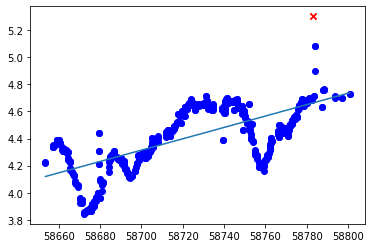

In [261]:
folder = '1H2106'
seed= 0
sep=','
start_col=0
batch_size=8
min_length=10


np.random.seed(seed) # for the shuffle
if not os.path.isdir(folder):
    raise Exception(f"{folder} is not a directory")
    
##################################
# initializing the DataSet objects 
##################################
lcs = DataSet(name=folder, min_length=min_length, sep=sep, start_col=start_col)
band_folders = os.listdir(folder)
for band_folder in band_folders:
    band = band_folder.lower()
    lcs.add_band(band, os.path.join(folder, band_folder))
    
    
### preprocessing functions ####################################################################
lcs.filter()
lcs.resample_lcs()
#lcs.prune_outliers()
lcs.prune_graham(plot=True, index=0)
lcs.chop_lcs()
###################################
lcs.set_excess_vars()
lcs.set_mean_mags()
###################################
lcs.normalize() 
lcs.formatting()
lcs.set_union_tp() # maybe do this as some regularly sequenced bit
print(f'dataset created w/ shape {lcs.dataset.shape}')
######## done preprocessing ########################################################################################################
lcs.set_data_obj(batch_size=batch_size)

In [262]:
args = Namespace(batch_size=8, bound_variance=False, const_var=False,dropout=0.2, 
                 elbo_weight=1, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=True, 
                 kl_zero=False, latent_dim=32, lr=0.001, mixing='concat_and_mix', mse_weight=4,
                 print_at=1,inc_errors=False, frac=0.5,scheduler=False, warmup=4000,niters=1000, 
                 norm=True, normalize_input='znorm', num_ref_points=32, rec_hidden=32, recon_loss=False, 
                 save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512, device='mps')


In [263]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('mps' if torch.has_mps else 'cpu')
dim = lcs.data_obj['input_dim']

In [264]:
net = model.load_network(args, dim, lcs.data_obj['union_tp'])
params = list(net.parameters())
optimizer = optim.Adam(params, lr=0.001)
train_loader = lcs.data_obj["train_loader"]
test_loader = lcs.data_obj["test_loader"]
val_loader = lcs.data_obj["valid_loader"]
loss = 1000000


In [269]:
for g in optimizer.param_groups:
    g['lr'] = 0.01
    
lcs.set_target_x(n=100)
recons = []
end_times = []
nlls = []
mses = []
epochs = []
lrs = []


all_tp = []
all_targets = []
all_inputs = []
all_target_tp = []
all_preds = []

In [ ]:
best_loss = loss 
patience_counter = 0
########################################
model_size = utils.count_parameters(net) 
start = time.time()
for itr in range(1, 1+10):
    train_loss = 0
    train_n = 0
    avg_loglik, avg_wloglik, avg_kl, mse, wmse, mae = 0, 0, 0, 0, 0, 0
    ###########set learning rate based on our scheduler###############
    if args.scheduler == True: 
        args.lr = utils.update_lr(model_size, itr, args.warmup)
        for g in optimizer.param_groups:
            g['lr'] = args.lr 
    ##################################################################    
    if args.kl_annealing:
        wait_until_kl_inc = 10000
        if itr < wait_until_kl_inc:
            kl_coef = 0.
        else:
            kl_coef = (1 - 0.999999 ** (itr - wait_until_kl_inc))
    elif args.kl_zero:
        kl_coef = 0
    else:
        kl_coef = 1
    ##################################################################
    for train_batch in train_loader:
        batch_len = train_batch.shape[0]
        ### errorbar stuff ##############################
        errorbars = torch.swapaxes(train_batch[:,:,:,2], 2,1)
        weights = errorbars.clone()
        weights[weights!=0] = 1 / weights[weights!=0]
        errorbars[errorbars!=0] = torch.log(errorbars[errorbars!=0])
        logerr = errorbars.to(device)
        weights = weights.to(device)
        ############################################################
        subsampled_mask = utils.make_masks(train_batch, frac=args.frac)
        train_batch = train_batch.to(device)
        subsampled_mask = subsampled_mask.to(device)
        recon_mask = torch.logical_xor(subsampled_mask, train_batch[:,:,:,1])
        context_y = torch.cat((
          train_batch[:,:,:,1] * subsampled_mask, subsampled_mask
        ), 1).transpose(2,1)
        recon_context_y = torch.cat((
            train_batch[:,:,:,1] * recon_mask, recon_mask
        ), 1).transpose(2,1)
        #############################################################
        loss_info = net.compute_unsupervised_loss(
            train_batch[:, 0, :,0],
            context_y,
            train_batch[:, 0, :,0],
            recon_context_y,
            logerr,
            weights,
            num_samples=args.k_iwae,
            beta=kl_coef,
        )
        optimizer.zero_grad()
        if args.inc_errors:
            loss_info.weighted_comp_loss.backward()
        else:
            loss_info.composite_loss.backward()
        optimizer.step()
        #########################################################
        train_loss += loss_info.composite_loss.item() * batch_len
        avg_loglik += loss_info.loglik * batch_len
        avg_wloglik += loss_info.wloglik * batch_len
        avg_kl += loss_info.kl * batch_len
        mse += loss_info.mse * batch_len
        wmse += loss_info.wmse * batch_len
        mae += loss_info.mae * batch_len
        train_n += batch_len
        #########################################################
    print(f'{itr},', end='', flush=True)
    if itr % args.print_at == 0:
        print(
            '\tIter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg wnll: {:.4f}, avg kl: {:.4f}, '
            'mse: {:.6f}, wmse: {:.6f}, mae: {:.6f}'.format(
                itr,
                train_loss / train_n,
                -avg_loglik / train_n,
                -avg_wloglik / train_n,
                avg_kl / train_n,
                mse / train_n,
                wmse / train_n,
                mae / train_n))
    valid_nll_loss, valid_mse_loss = utils.evaluate_hetvae(
        net,
        dim,
        train_loader, # should be val_loader
        0.5,
        k_iwae=args.k_iwae,
        device=args.device
        )
    
    ###################################### for animation ####################################
    epochs.append(itr)
    nlls.append(valid_nll_loss)
    mses.append(valid_mse_loss)
    end = time.time()
    end_times.append(end)
    qz_preds, tp, targets, inputs, target_tp, preds = utils.predict(test_loader, net, device='mps', k_iwae=20, subsample=False, target_x=lcs.target_x, plot=False)
    # all points 
    all_tp.append(tp)
    all_targets.append(targets)
    # conditioned on
    all_inputs.append(inputs)
    # projected to 
    all_target_tp.append(target_tp)
    all_preds.append(preds)

(200, 3, 435, 1)


IndexError: index 3 is out of bounds for axis 0 with size 3

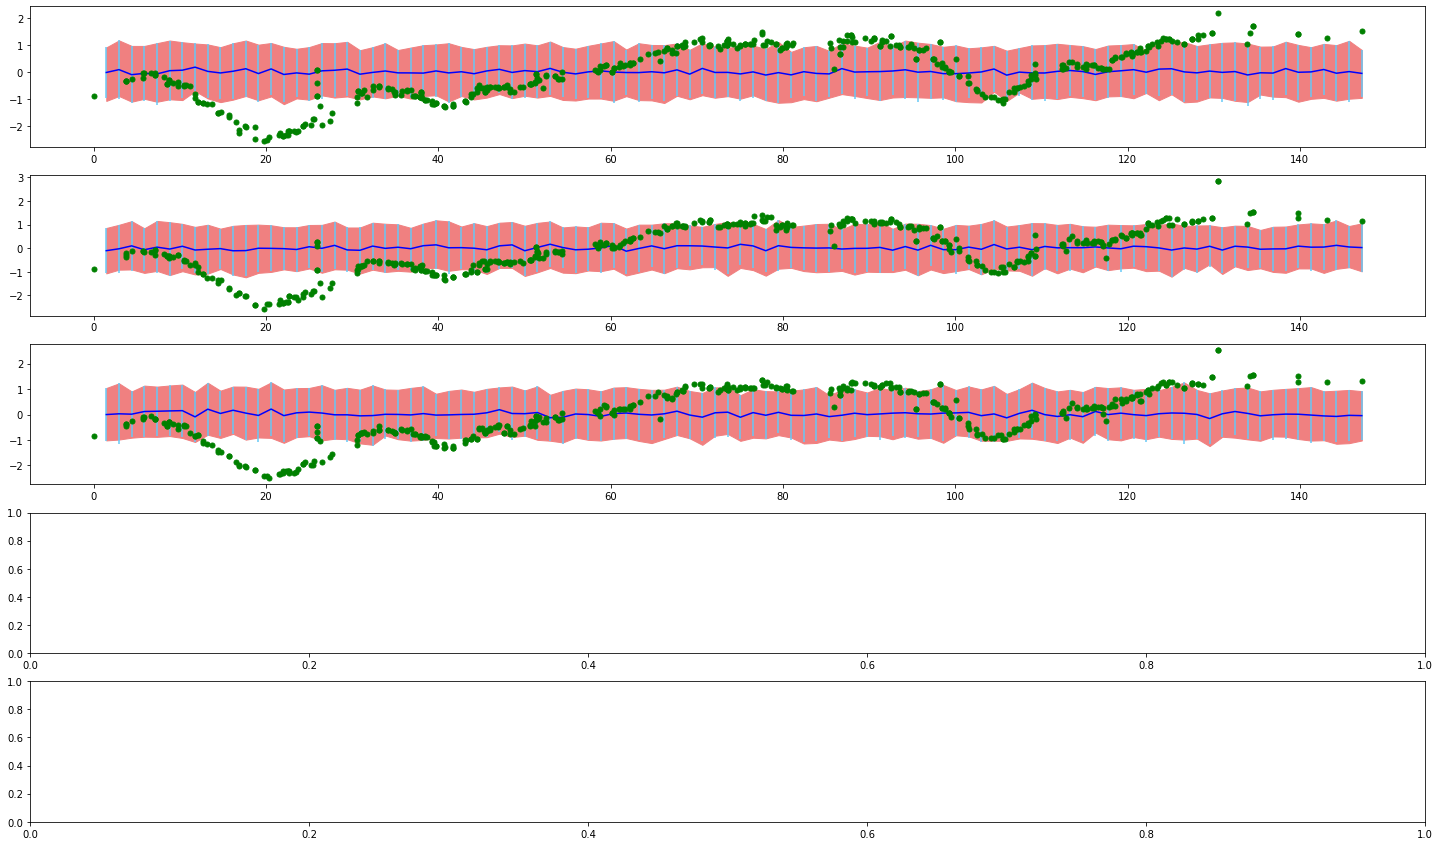

In [267]:
median = preds.mean(0)
quantile2 = np.quantile(preds, 0.841, axis=0)
quantile1 = np.quantile(preds, 0.159, axis=0)
print(preds.shape)
fig,ax = plt.subplots(5,1,figsize=(25,15))
for i in range(4):
    #### remove padding and masked vals
    nonzero_pred = target_tp[i].nonzero()[0]
    nonzero_in = inputs[i].nonzero()[0]
    nonzero_targets = targets[i].nonzero()[0]

    ax[i].fill_between(target_tp[i,nonzero_pred], quantile1[i,nonzero_pred,0], quantile2[i,nonzero_pred,0], label='error envelope',color='lightcoral')
    ax[i].errorbar(target_tp[i, nonzero_pred], median[i, nonzero_pred,0], yerr=(quantile2[i,nonzero_pred,0] - median[i, nonzero_pred,0]), c='blue', ecolor='#65c9f7', label='prediction')
    # conditoned on points
    #ax[i].scatter(tp[i, nonzero_in], inputs[i, nonzero_in], c='black', marker='x', zorder=30, label='conditioned on', s=100)
    # all points 
    ax[i].scatter(tp[i, nonzero_targets], targets[i, nonzero_targets], c='green', marker='.', s=100, zorder=100)


In [223]:
elapsed = [f'{round((end - start),3)}' for end in end_times]
mses = [round(float(mse), 3) for mse in mses]
nlls = [round(float(nll), 3) for nll in nlls]
elapsed.insert(0,'0')
print(elapsed, mses, nlls)

['0', '-51.896', '-50.245', '-48.777', '-47.458', '-46.189', '-44.935', '-43.656', '-42.394', '-41.131', '-39.821', '1.009', '7.908', '14.62', '20.917', '26.807', '32.826', '39.213', '45.414', '51.624', '58.419'] [0.95, 0.949, 0.948, 0.948, 0.949, 0.949, 0.949, 0.949, 0.949, 0.95, 0.951, 0.953, 0.963, 0.957, 0.95, 0.95, 0.949, 0.953, 0.958, 0.955] [1.475, 1.435, 1.41, 1.397, 1.393, 1.395, 1.4, 1.406, 1.41, 1.411, 1.411, 1.409, 1.409, 1.403, 1.397, 1.395, 1.394, 1.396, 1.4, 1.4]


In [224]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

In [225]:
print(all_tp[0].shape, all_targets[0].shape, all_inputs[0].shape, all_target_tp[0].shape, all_preds[0].shape)

(8, 435) (8, 435, 1) (8, 435, 1) (8, 435) (2, 8, 435, 1)


In [226]:
all_preds[0].shape

(2, 8, 435, 1)

In [227]:
np.quantile(all_preds[0], 0.841, axis=0).shape

(8, 435, 1)

In [228]:
i = 1


y_pred = all_preds[i].mean(0)[ex] # 967,1 
t_pred = all_target_tp[i][ex] #(967,)
q2 = np.quantile(all_preds[i], 0.841, axis=0)[ex] #(967,1)
q1 = np.quantile(all_preds[i], 0.159, axis=0)[ex] #(967,1)

## example itself
t_gt = all_tp[0][ex] # (967,)
y_gt = all_targets[0][ex]

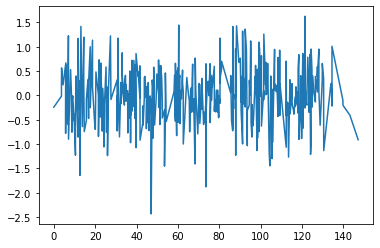

In [229]:
plt.plot(t_pred, y_pred)

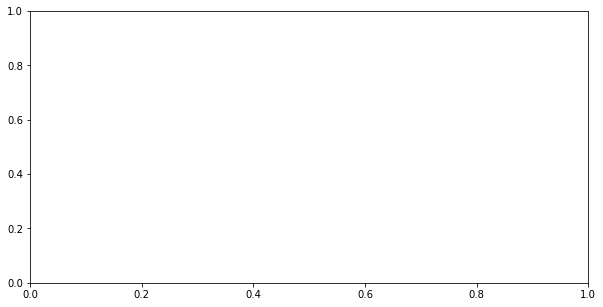

In [233]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
ex = 1

    
# all_preds = 
def animate(i):
    ## predictions
    y_pred = all_preds[i].mean(0)[ex]
    t_pred = all_target_tp[i][ex]
    q2 = np.quantile(all_preds[i], 0.841, axis=0)[ex]
    q1 = np.quantile(all_preds[i], 0.159, axis=0)[ex] 
    
    ## example itself
    t_gt = all_tp[0][ex] # (967,)
    y_gt = all_targets[0][ex]
    
    ax.clear()
    w=2.0
    
    nonzero_pred = t_pred.nonzero()[0]
    nonzero_targets = y_gt.nonzero()[0]
    
          
    ax.fill_between(t_pred[nonzero_pred], q1[nonzero_pred,0], q2[nonzero_pred,0], label='error envelope',color='lightcoral')
    ax.errorbar(t_pred[nonzero_pred], y_pred[nonzero_pred,0], yerr=(q2[nonzero_pred,0] - y_pred[nonzero_pred,0]), c='blue', ecolor='#65c9f7', label='prediction')
    ax.scatter(t_gt[nonzero_targets], y_gt[nonzero_targets], c='green', marker='.', s=100, zorder=100)
    
    ax.text(58660, 5, f'epoch: {epochs[i]}, mse: {mses[i]}, \n nll: {nlls[i]}, elapsed time: {elapsed[i]} sec', fontsize=10)
    #ax.set_xlim([58670,58700])
    ax.set_ylim([-2,2])
    ax.set_xlabel('MJD')
    ax.set_ylabel('Flux')
    ax.set_title('AGN 1H2106-099, G Band')
    


In [236]:
ani = FuncAnimation(fig, animate, frames=10, interval=100, repeat=False)

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [237]:
ani